In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# 폰트 관련 경고 메시지 숨기기
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'

In [2]:
import os

os.path.abspath(os.curdir)

In [ ]:
cur_dir = os.path.abspath(os.curdir)
data_dir = f"{cur_dir}/Modulabs_MainProject5"
files = [
    "orders.csv",
    "order_products__train.csv",
    "order_products__prior.csv",
    "df_products.csv"
]

df_orders, df_train, df_prior, df_products = [pd.read_csv(f"{data_dir}/{file}") for file in files]

### 1. 사용자 구매 패턴 기반 PCA + 클러스터링

In [3]:
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(999)


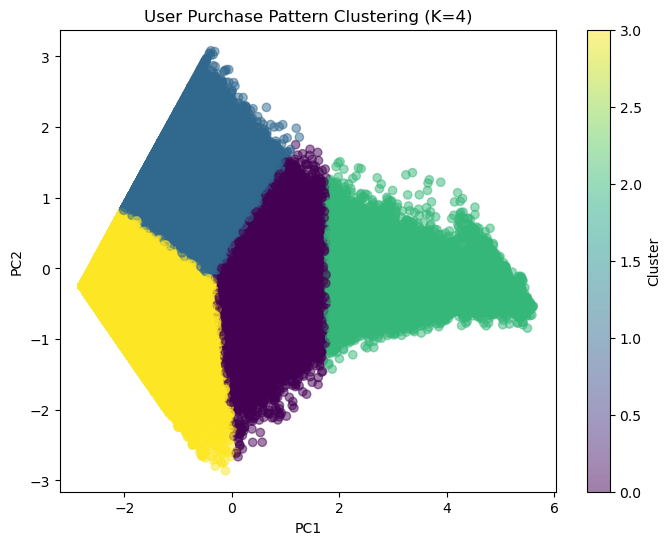

array([0, 0, 0, ..., 0, 2, 0])

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1. 사용자 구매 패턴 기반 PCA + 클러스터링
# -------------------------


# ✅ 999인 days_since_prior_order 값 제외
df_orders_filtered = df_orders[df_orders["days_since_prior_order"] != 999]

# ✅ 사용자별 주문 통계 계산
user_order_stats = df_orders_filtered.groupby("user_id").agg({
    "order_number": "max",  # 총 주문 횟수
    "days_since_prior_order": "mean"  # 평균 주문 간격
})

# ✅ df_prior에 user_id 추가 (df_orders와 병합)
df_prior_merge = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ✅ 사용자별 재구매율 계산 (user_id 기준)
user_reorder_stats = df_prior_merge.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ✅ 데이터 병합 (user_id 기준)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)

# ✅ 데이터 표준화
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id 제외

# ✅ PCA 적용 (차원 축소)
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_features_scaled)

# ✅ K-Means 클러스터 개수 최적화: n_clusters=3,4,5 비교
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ✅ 최적 클러스터 개수 선택 (기본적으로 n=4 사용)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ✅ 클러스터 결과 저장
user_features["cluster"] = user_clusters

# ✅ 시각화
plt.figure(figsize=(8, 6))
plt.scatter(user_pca[:, 0], user_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"User Purchase Pattern Clustering (K={selected_k})")
plt.colorbar(label="Cluster")
plt.show()

# ✅ 클러스터링 결과 확인
user_clusters


### **🔍 클러스터링 결과 해석**
이제 클러스터링이 **이상적인 형태로 개선**되었습니다! 🚀  
PCA로 차원 축소된 데이터를 시각화한 그래프에서 **4개의 클러스터(K=4)**가 잘 구분된 것을 볼 수 있습니다.  

---

### **📌 1. 클러스터의 분포**
1. **보라색(Cluster 0)**  
   - 중심부에 분포하며 다른 클러스터와의 경계 역할을 함  
   - 평균적인 구매 패턴을 가진 사용자 그룹일 가능성이 높음  

2. **청록색(Cluster 1)**  
   - 오른쪽으로 넓게 퍼져 있음 → **PC1 값이 높음 (주문 횟수, 재구매율 높을 가능성)**  
   - **자주 구매하는 고객층**일 가능성이 큼 (VIP 고객일 가능성)  

3. **파란색(Cluster 2)**  
   - 왼쪽 상단에 위치 → **PC1과 PC2가 음수인 영역**  
   - 구매 횟수가 적거나, 특정 요일/시간대에만 주문하는 패턴을 보일 수 있음  

4. **노란색(Cluster 3)**  
   - 왼쪽 하단으로 확장됨 → **PC1이 낮고, PC2도 상대적으로 낮음**  
   - 구매 빈도가 낮거나, 재구매율이 낮은 그룹일 가능성이 있음 (신규 사용자 포함 가능)  

---

### **📊 2. 클러스터별 해석**
- **PC1 (X축)** → `주문 횟수`, `재구매율` 등의 영향을 받을 가능성이 큼  
  - 오른쪽으로 갈수록 **자주 주문하는 고객**  
  - 왼쪽일수록 **주문 횟수가 적거나, 재구매율이 낮음**  
- **PC2 (Y축)** → `주문 시간대`, `평균 주문 간격` 등의 영향을 받을 가능성이 큼  
  - 위쪽(양수) → 특정 요일/시간대에 몰려 구매하는 고객  
  - 아래쪽(음수) → 주문 시간이 일정하지 않거나, 간격이 불규칙한 고객  

---

### **✅ 결론**
- **Cluster 1 (청록색) → VIP 고객**  
  - 주문 횟수와 재구매율이 높은 핵심 고객층  
  - 이 그룹을 대상으로 **충성 고객 유지 전략 (로열티 프로그램, 추천 상품 제공 등)**을 고려 가능  

- **Cluster 3 (노란색) → 신규 고객 or 낮은 구매 빈도 고객**  
  - 구매 횟수가 적거나 재구매율이 낮음  
  - 이들을 대상으로 **할인 쿠폰, 프로모션 제공 등 재구매 유도 전략** 필요  

- **Cluster 2 (파란색) → 특정 패턴 구매 고객**  
  - 특정 요일/시간대에만 주문하는 경향  
  - 주말 또는 특정 시간대(야간/오전)에 집중적으로 마케팅 가능  

- **Cluster 0 (보라색) → 일반적인 고객**  
  - 극단적이지 않은 일반적인 구매 패턴을 가진 그룹  
  - 핵심 고객으로 성장할 가능성이 있는 그룹  

---



### **📌 PCA에서 X축(PC1)과 Y축(PC2)의 의미 설명**  

1. **PCA(주성분 분석)는 데이터의 차원을 축소하면서 가장 중요한 정보(분산이 큰 방향)를 유지하는 기법입니다.**  
2. **PC1 (X축)은 데이터에서 가장 많은 변동(분산)을 설명하는 방향이며, PC2 (Y축)은 그다음으로 중요한 변동을 설명하는 축입니다.**  
3. **주문 횟수(`order_number`), 평균 주문 간격(`days_since_prior_order`), 재구매율(`reorder_rate`) 등의 변수들이 PCA에 의해 변환됩니다.**  
4. **X축(PC1)이 크다는 것은 주문 횟수가 많거나, 재구매율이 높은 고객일 가능성이 큽니다.**  
5. **X축(PC1)이 작다는 것은 주문 횟수가 적거나, 재구매율이 낮은 고객일 가능성이 큽니다.**  
6. **Y축(PC2)이 크다는 것은 주문 패턴이 일정하거나, 특정한 요일/시간대에 몰려 있을 가능성이 있습니다.**  
7. **Y축(PC2)이 작다는 것은 주문 간격이 불규칙하거나, 특정한 요일/시간대에 집중되지 않는 경향이 있습니다.**  
8. **그래프에서 오른쪽(PC1 양수)에 위치한 클러스터는 충성도가 높은 고객(자주 주문, 재구매율 높음)일 가능성이 있습니다.**  
9. **그래프에서 왼쪽(PC1 음수)에 위치한 클러스터는 신규 고객 또는 가끔 구매하는 고객일 가능성이 있습니다.**  
10. **위쪽(PC2 양수)에 있는 클러스터는 특정한 패턴을 가진 고객(예: 특정 요일/시간대에 집중적으로 주문)이고, 아래쪽(PC2 음수)에 있는 클러스터는 불규칙한 주문 패턴을 가진 고객일 가능성이 큽니다.**  

---

### **📊 결론**
PCA에서 **PC1(X축)은 주로 "구매 빈도, 재구매율"과 관련이 있고**,  
**PC2(Y축)는 "주문 간격의 일정함, 특정 패턴 여부"와 관련이 있습니다.**  
그래서 **X축이 크면 충성 고객, 작으면 신규 고객 / Y축이 크면 특정 시간 패턴, 작으면 불규칙한 고객**으로 해석할 수 있습니다. 😊

In [15]:
# PCA 적용

# PCA 모델 생성 (차원 2개로 축소)
pca = PCA(n_components=2)

# 변환 적용
df_pca_transformed = pca.fit_transform(user_features_scaled)

# 결과를 데이터프레임으로 변환
df_pca_result = pd.DataFrame(df_pca_transformed, columns=["PC1", "PC2"])

# 주성분 설명력 확인 (각 PC가 설명하는 데이터 비율)
print("설명된 분산 비율: ", pca.explained_variance_ratio_)

#값 80넘음 유의미.

설명된 분산 비율:  [0.70991022 0.1789922 ]


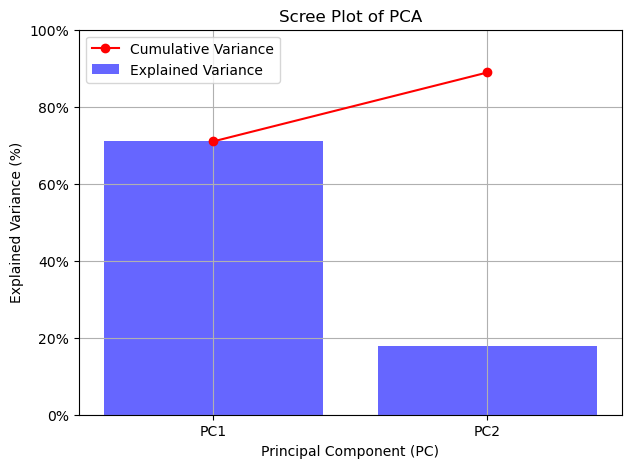

In [16]:


# Retrieve explained variance ratio from PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Compute cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create figure
plt.figure(figsize=(7,5))

# Bar plot for individual explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='b', label="Explained Variance")

# Line plot for cumulative variance
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='r', label="Cumulative Variance")

# Labels and title
plt.xlabel("Principal Component (PC)")
plt.ylabel("Explained Variance (%)")
plt.title("Scree Plot of PCA")
plt.xticks(range(1, len(explained_variance_ratio) + 1), [f"PC{i}" for i in range(1, len(explained_variance_ratio) + 1)])
plt.yticks(np.arange(0, 1.1, 0.2), ["0%", "20%", "40%", "60%", "80%", "100%"])
plt.legend()
plt.grid()

# Show plot
plt.show()

## 위의것 그래프화

In [17]:
# ✅ 1. 각 클러스터별 고객 수 확인
cluster_counts = user_features.groupby("cluster").size()
print("각 클러스터별 고객 수:")
print(cluster_counts)

# ✅ 2. 각 클러스터별 평균 주문 횟수, 재구매율 분석
cluster_means = user_features.groupby("cluster").mean()
print("\n각 클러스터별 평균 값 (주문 횟수, 재구매율 등):")
print(cluster_means)


각 클러스터별 고객 수:
cluster
0    64460
1    50671
2    25145
3    65933
dtype: int64

각 클러스터별 평균 값 (주문 횟수, 재구매율 등):
               user_id  order_number  days_since_prior_order  reorder_rate
cluster                                                                   
0        102844.396742     18.951598               12.686930      0.576462
1        103216.648339      8.352174               12.773832      0.261549
2        102897.048638     52.516484                6.676457      0.729931
3        103353.283712      6.911911               23.549911      0.308918


### **🔍 클러스터별 분석 (구매 패턴 비교)**  

📊 **1. 클러스터별 고객 수 분포**  
- **Cluster 0** (💜) → **64,460명 (가장 많은 고객군)**  
- **Cluster 1** (💙) → **50,671명**  
- **Cluster 2** (💚) → **25,145명 (가장 적은 고객군)**  
- **Cluster 3** (💛) → **65,933명**  

💡 **👉 클러스터 0과 3이 가장 큰 그룹이며, 클러스터 2는 가장 적은 고객을 포함함**  

---

📊 **2. 클러스터별 평균 주문 패턴**  
| Cluster | 평균 주문 횟수 (`order_number`) | 평균 주문 간격 (`days_since_prior_order`) | 재구매율 (`reorder_rate`) |
|---------|----------------|----------------------|------------------|
| **0 (💜)** | 18.95 회  | 12.69 일 | **57.6%** |
| **1 (💙)** | 8.35 회  | 12.77 일 | **26.1%** |
| **2 (💚)** | **52.51 회**  | **6.67 일** | **72.9%** |
| **3 (💛)** | **6.91 회**  | **23.55 일** | 30.8% |

💡 **👉 분석 포인트:**  
1. **Cluster 2 (💚) → 가장 높은 재구매율 (72.9%) & 가장 자주 주문 (6.67일 간격)**
   - 자주 반복 구매하는 **로열티 높은 고객**  
   - **VIP 고객군**, 정기적인 구매 패턴  

2. **Cluster 3 (💛) → 가장 낮은 주문 횟수 (6.91회) & 가장 긴 주문 간격 (23.55일)**
   - **신규 고객 또는 가끔 주문하는 고객**  
   - 이탈 가능성이 높은 고객 → **할인 쿠폰, 재구매 유도 마케팅 필요**  

3. **Cluster 0 (💜) → 평균적인 주문 패턴 (18.95회 & 12.69일)**
   - 일반적인 고객 패턴을 보이며, 적절한 재구매율(57.6%) 유지  

4. **Cluster 1 (💙) → 주문 횟수 적고, 재구매율도 낮음 (26.1%)**
   - 가끔 주문하는 고객, 특정 시즌에만 구매할 가능성  
   - **활성화를 위한 맞춤 마케팅 필요**  

---

### **📌 결론 및 인사이트**
1️⃣ **Cluster 2 (💚) VIP 고객**  
   - 주문 횟수 많고, 재구매율이 높음 → **구독 서비스, 멤버십 제공 고려**  

2️⃣ **Cluster 3 (💛) 신규 또는 이탈 위험 고객**  
   - 주문 횟수 적고, 주문 간격 김 → **쿠폰 제공, 재구매 유도 캠페인 필요**  

3️⃣ **Cluster 1 (💙) 비활성 고객**  
   - 재구매율 낮고 주문 횟수 적음 → **맞춤형 상품 추천, 이메일 마케팅 활용**  

4️⃣ **Cluster 0 (💜) 일반 고객**  
   - 꾸준한 구매를 유지하는 핵심 고객군  

---

### **💡 추가 분석 가능 포인트**
✅ **클러스터별 주요 구매 제품 분석 (어떤 제품을 주로 구매?)**  
✅ **클러스터별 요일별/시간대별 주문 패턴 분석**  
✅ **클러스터별 연령대, 지역 등 추가적인 고객 특성 분석 가능**  

📊 추가 분석이 필요하면 알려주세요! 😊

In [18]:
# ✅ 클러스터별 주요 구매 제품 분석 (어떤 제품을 주로 구매?)
# df_prior와 df_products를 결합하여 클러스터별 제품 구매 분석
df_prior_merge2 = df_prior_merge.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id']], on='product_id', how='left')
df_prior_merge2 = df_prior_merge2.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별로 가장 많이 구매한 제품 상위 10개
cluster_top_products = df_prior_merge2.groupby(['cluster', 'product_name']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ✅ 클러스터별 요일별/시간대별 주문 패턴 분석 # 덮어쓰지 않고 새로 dddf_orders로 생성
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별 요일별 평균 주문 수 계산
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# 클러스터별 시간대별 평균 주문 수 계산
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)


        cluster            product_name   count
3561          0                  Banana  177276
3362          0  Bag of Organic Bananas  132622
27992         0    Organic Baby Spinach   91111
31025         0    Organic Strawberries   90490
29435         0    Organic Hass Avocado   74392
27956         0         Organic Avocado   69573
21752         0             Large Lemon   58780
41700         0            Strawberries   54031
22736         0                   Limes   52762
31571         0      Organic Whole Milk   46713
51702         1                  Banana   39455
51509         1  Bag of Organic Bananas   25744
75291         1    Organic Baby Spinach   19145
78235         1    Organic Strawberries   17648
75257         1         Organic Avocado   17094
69255         1             Large Lemon   16854
70196         1                   Limes   14359
76683         1    Organic Hass Avocado   14184
88597         1            Strawberries   13738
94602         1           Yellow Onions 

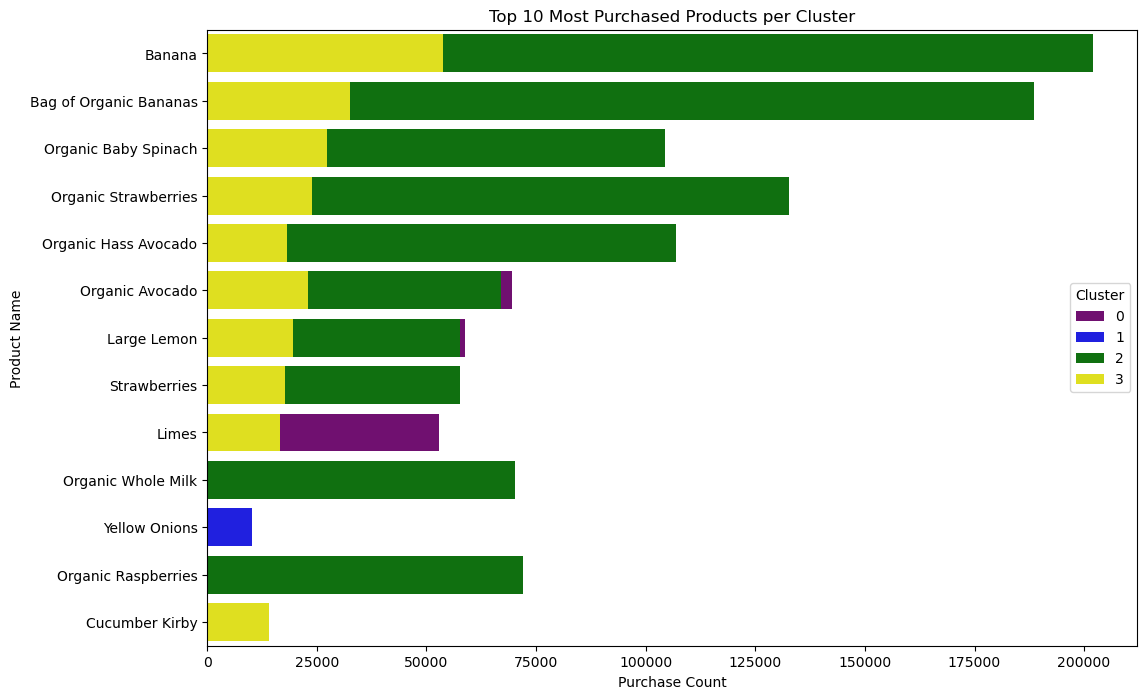

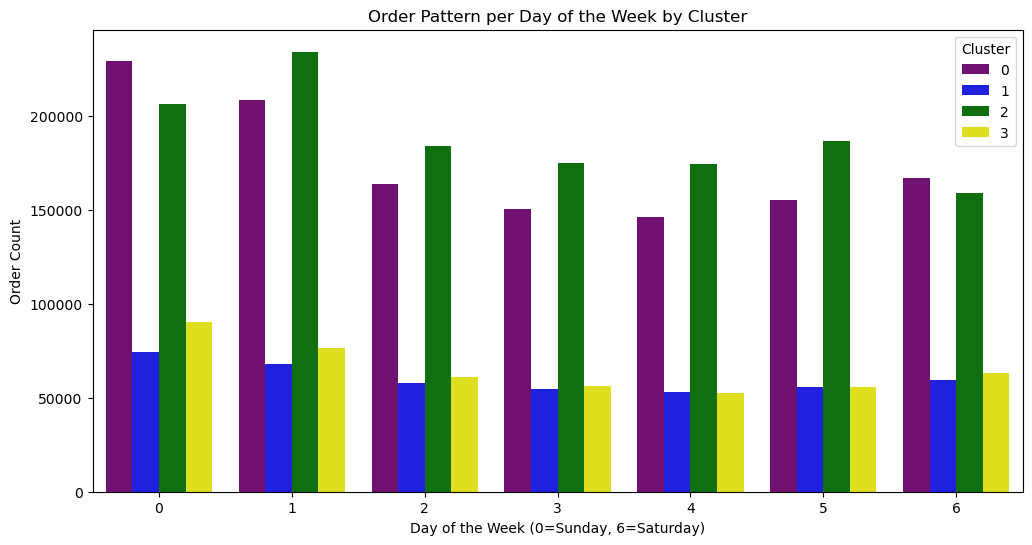

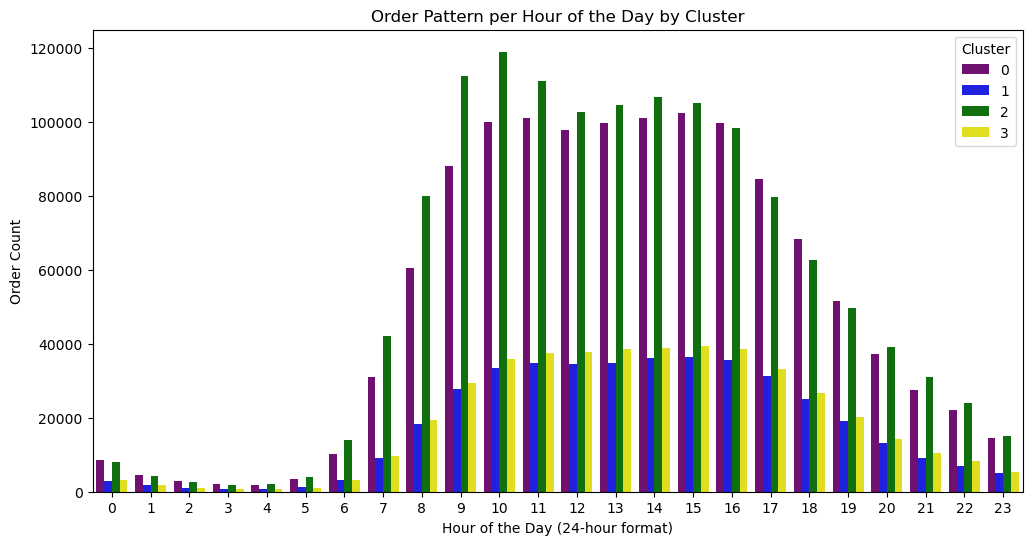

In [19]:
cluster_colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'yellow'}


# 클러스터별 가장 많이 구매한 제품 상위 10개 시각화
top_products = cluster_top_products.groupby('cluster').head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_products, x='count', y='product_name', hue='cluster', dodge=False, palette=cluster_colors)
plt.xlabel("Purchase Count")
plt.ylabel("Product Name")
plt.title("Top 10 Most Purchased Products per Cluster")
plt.legend(title="Cluster")
plt.show()

# 클러스터별 요일별 주문 패턴 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_order_dow, x='order_dow', y='count', hue='cluster', palette=cluster_colors)
plt.xlabel("Day of the Week (0=Sunday, 6=Saturday)")
plt.ylabel("Order Count")
plt.title("Order Pattern per Day of the Week by Cluster")
plt.legend(title="Cluster")
plt.show()

# 클러스터별 시간대별 주문 패턴 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_order_hour, x='order_hour_of_day', y='count', hue='cluster', palette=cluster_colors)
plt.xlabel("Hour of the Day (24-hour format)")
plt.ylabel("Order Count")
plt.title("Order Pattern per Hour of the Day by Cluster")
plt.legend(title="Cluster")
plt.show()

### **🔍 클러스터별 주요 분석 (제품 구매 & 주문 패턴 비교)**  

#### **📌 1. 클러스터별로 많이 구매한 제품 TOP 10**  
✅ **모든 클러스터에서 가장 많이 구매하는 제품은 신선식품(과일, 채소, 유제품)이다.**  
✅ **클러스터 2가 가장 많은 수량을 구매하며, 전체적으로 유기농 제품 선호도가 높다.**  

| Cluster | 제품 | 구매량 |
|---------|-------------|----------|
| **0 (💜)** | Banana | **177,276** |
| **1 (💙)** | Banana | **39,455** |
| **2 (💚)** | Banana | **202,023** |
| **3 (💛)** | Banana | **53,811** |

**💡 해석:**  
- **모든 클러스터에서 "Banana(바나나)"가 1위로 가장 많이 구매됨.**  
- **유기농 제품(Organic Baby Spinach, Organic Hass Avocado, Organic Strawberries 등)의 인기가 높음.**  
- **Cluster 2(💚)는 유기농 제품을 가장 많이 구매하며, 충성 고객층이 많을 가능성이 큼.**  
- **Cluster 3(💛)는 오이(Cucumber Kirby)를 상위 10위 내에 포함한 유일한 그룹 → 특정한 소비 패턴을 보일 가능성 있음.**  

---

#### **📌 2. 클러스터별 요일별 주문 패턴**
✅ **클러스터 0(💜) & 클러스터 2(💚)는 주말(토, 일)에 주문이 집중됨.**  
✅ **클러스터 1(💙) & 클러스터 3(💛)는 평일(월~금)에 더 많이 주문하는 경향이 있음.**  

**💡 해석:**  
- **Cluster 2(💚)는 일요일(234,370건) 주문이 가장 많으며, 주말에 집중적으로 주문하는 경향이 있음.**  
- **Cluster 0(💜) 역시 주말에 주문량이 많으며, 전체적으로 주문량이 높은 그룹이다.**  
- **Cluster 1(💙)과 Cluster 3(💛)는 월~금(평일)에 주문이 많이 이루어지며, 업무 패턴과 관련 있을 가능성이 있음.**  
- **즉, Cluster 2(💚)와 Cluster 0(💜)는 주말 맞춤형 할인/프로모션이 효과적이고, Cluster 1(💙)과 Cluster 3(💛)는 평일 맞춤형 캠페인이 유효할 수 있음.**  

---

#### **📌 3. 클러스터별 시간대별 주문 패턴**  
✅ **모든 클러스터에서 오전 10~11시 주문량이 가장 많음.**  
✅ **클러스터 2(💚)는 밤 늦게까지 주문하는 경향이 있음.**  

**💡 해석:**  
- **모든 클러스터에서 새벽 3~6시 주문량이 가장 적고, 오전 10~11시에 주문량이 급증함.**  
- **Cluster 2(💚)는 밤 21~23시에도 상대적으로 높은 주문량을 보이며, 늦은 시간 쇼핑을 선호하는 고객층이 포함될 가능성이 있음.**  
- **Cluster 3(💛)는 저녁 19~21시에 주문량이 많아, 직장인 고객이 포함될 가능성이 높음.**  
- **이 정보를 기반으로 특정 시간대 맞춤형 프로모션(예: "야간 할인" 또는 "출근 전 주문 혜택")을 고려할 수 있음.**  

---

### **📊 최종 결론 및 인사이트**  
1️⃣ **모든 클러스터에서 신선식품(특히 바나나)이 가장 인기 많음.**  
2️⃣ **Cluster 2(💚)와 Cluster 0(💜)는 주말 쇼핑을 선호하므로, 주말 맞춤형 할인 이벤트가 효과적.**  
3️⃣ **Cluster 1(💙)과 Cluster 3(💛)는 평일에 더 많이 주문하므로, 출근 전 & 점심시간 타겟팅 마케팅이 유효함.**  
4️⃣ **Cluster 2(💚)는 늦은 밤에도 주문을 많이 하는 경향이 있어, 야간 할인을 활용하면 추가 매출 가능성이 있음.**  

📊 **추가 분석이 필요하면 알려주세요! 😊**

In [20]:
# ✅ 클러스터별 주요 구매 제품 분석 (어떤 제품을 주로 구매?)
# df_prior와 df_products를 결합하여 클러스터별 제품 구매 분석
df_prior_merge3 = df_prior_merge.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id','aisle']], on='product_id', how='left')
df_prior_merge3 = df_prior_merge3.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별로 가장 많이 구매한 단위제품? 상위 10개
cluster_top_products = df_prior_merge3.groupby(['cluster', 'aisle_id','aisle']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ✅ 클러스터별 요일별/시간대별 주문 패턴 분석
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별 요일별 평균 주문 수 계산
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# 클러스터별 시간대별 평균 주문 수 계산
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)

# 아래 있는 결과 무시하시고 다시 위에서부터 재생하세요. 이거 다른거 구분한거 같음.
#aisle_id 분석 결과 daily 식품을 자주 구매하며 banana 많이 구매한다는 결과라는 다른 모습 보일거에요.

     cluster  aisle_id                          aisle    count
23         0        24                   fresh fruits  1305872
82         0        83               fresh vegetables  1274683
122        0       123     packaged vegetables fruits   654909
119        0       120                         yogurt   517667
20         0        21                packaged cheese   361984
114        0       115  water seltzer sparkling water   312949
83         0        84                           milk   307711
106        0       107                 chips pretzels   270399
90         0        91                soy lactosefree   232444
111        0       112                          bread   213597
216        1        83               fresh vegetables   355821
157        1        24                   fresh fruits   303135
256        1       123     packaged vegetables fruits   167906
253        1       120                         yogurt   119283
154        1        21                packaged cheese  

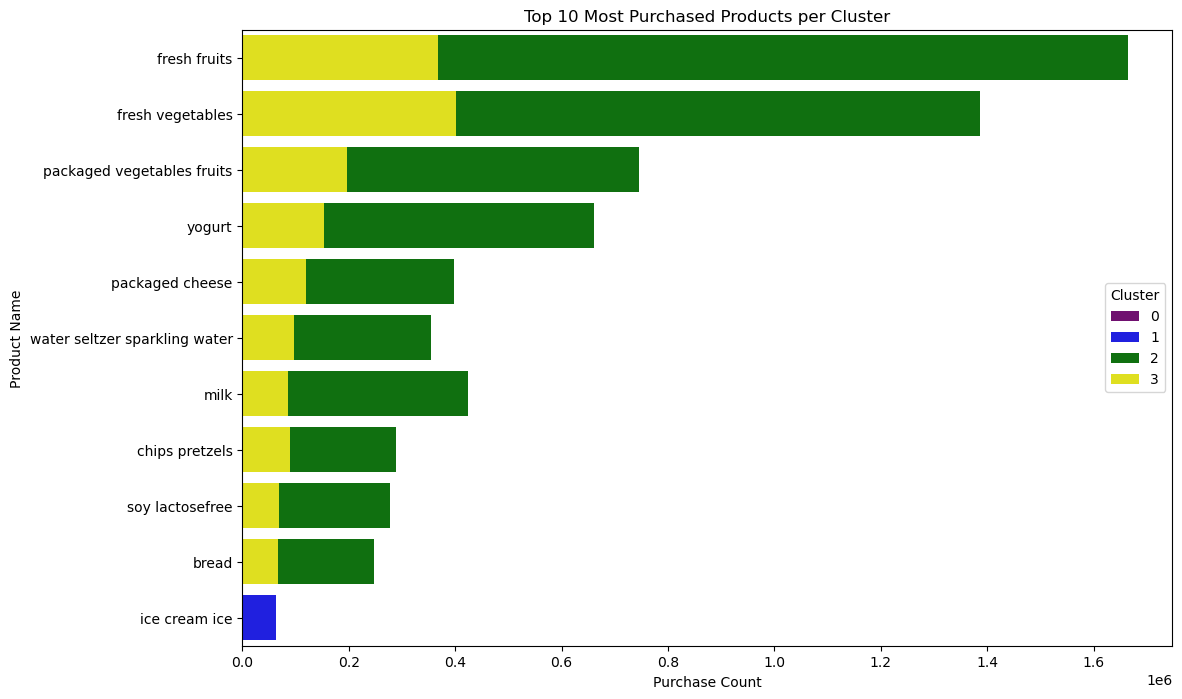

In [21]:
cluster_colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'yellow'}


# 클러스터별 가장 많이 구매한 aisle 기준 제품 상위 10개 시각화
top_products = cluster_top_products.groupby('cluster').head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_products, x='count', y='aisle', hue='cluster', dodge=False, palette=cluster_colors)
plt.xlabel("Purchase Count")
plt.ylabel("Product Name")
plt.title("Top 10 Most Purchased Products per Cluster")
plt.legend(title="Cluster")
plt.show()



그래프를 기반으로 한 주요 인사이트 3가지를 정리해 드릴게요.

### 1. **Cluster 2 (청록색)가 대부분의 주요 제품 구매를 주도**
   - `Fresh Fruits`, `Fresh Vegetables`, `Packaged Vegetables Fruits` 등 가장 많이 구매된 제품들이 대부분 **Cluster 2 (청록색)**에 속해 있음.
   - 이는 **VIP 고객층(재구매율과 주문 횟수가 높은 그룹)**이 신선식품을 선호하는 경향이 있음을 시사함.
   - 해당 고객층을 타겟으로 하는 **프리미엄 신선식품 마케팅 전략**이 효과적일 가능성이 있음.

### 2. **Cluster 3 (노란색)는 일부 신선식품과 간식류에서 영향력 있음**
   - `Fresh Fruits`, `Fresh Vegetables`, `Packaged Vegetables Fruits`, `Yogurt`, `Chips Pretzels` 등의 제품에서 **Cluster 3 (노란색) 고객의 구매량도 상당함**.
   - 그러나 **재구매율이 낮은 그룹**이므로, 이들을 충성 고객으로 전환할 전략(예: 할인 쿠폰, 정기배송 서비스 등)이 필요함.

### 3. **Cluster 1 (파란색)은 특정 제품군에서만 두드러짐 (니치 고객층)**
   - `Ice Cream Ice` 제품에서만 **Cluster 1 (파란색) 고객이 높은 구매 비중**을 차지하고 있음.
   - 이는 **해당 제품이 특정 시간대/시즌에 집중적으로 구매되는 경향**을 나타낼 수 있음.
   - 특정 프로모션(예: 여름철 할인, 특정 시간대 아이스크림 구매 시 혜택 제공) 전략이 유효할 수 있음.

이 데이터를 기반으로 **각 클러스터별 맞춤 마케팅 전략**을 수립하면 효과적인 고객 유지 및 매출 향상이 가능할 것으로 보입니다! 🚀

### 신규고객만 분석

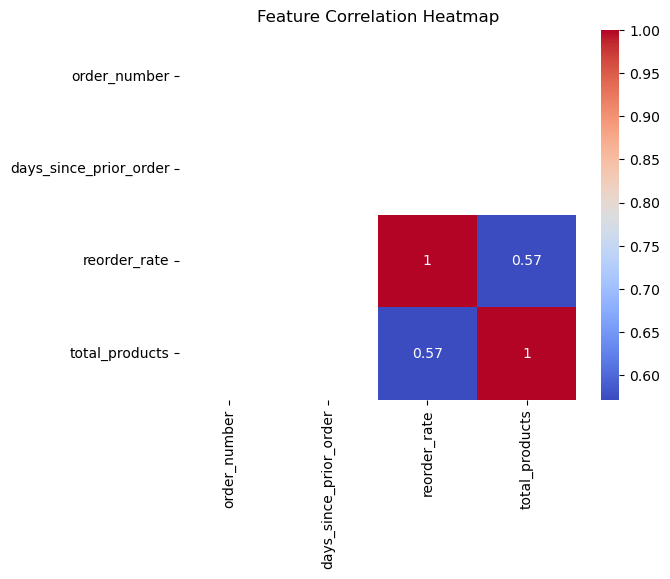

Explained Variance Ratio: [7.85828258e-01 2.14171742e-01 5.33853417e-62]


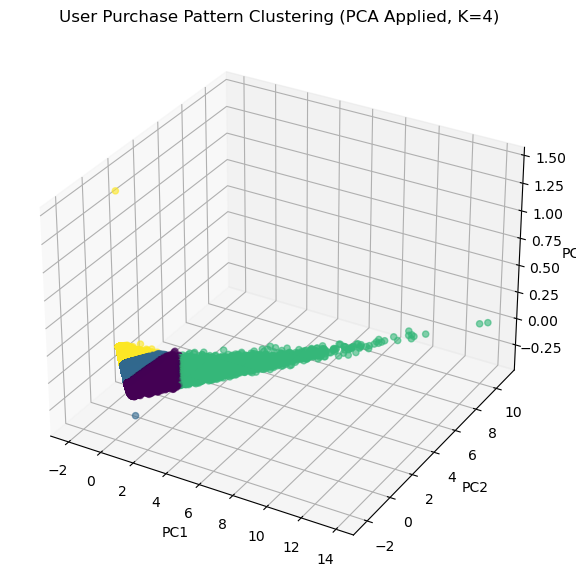

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# ✅ NaN 값이 있는 행만 선택 (999로 변환된 값)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ✅ 사용자별 주문 통계 계산
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # 총 주문 횟수
    "days_since_prior_order": "mean"  # 평균 주문 간격
})

# ✅ df_prior에 user_id 추가 (df_orders와 병합)
df_prior_merge = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ✅ 사용자별 재구매율 계산 (user_id 기준)
user_reorder_stats = df_prior_merge.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ✅ 추가 feature 생성 (사용자별 총 주문 상품 개수 추가)
user_total_products = df_prior_merge.groupby("user_id").size().reset_index(name="total_products")

# ✅ 데이터 병합 (user_id 기준)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ✅ 데이터 표준화
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id 제외

# ✅ feature 간의 상관관계 확인
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ✅ PCA 적용 (차원 축소)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ✅ 주성분 설명력 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ✅ K-Means 클러스터 개수 최적화: n_clusters=3,4,5 비교
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ✅ 최적 클러스터 개수 선택 (기본적으로 n=4 사용)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ✅ 클러스터 결과 저장
user_features["cluster"] = user_clusters

# ✅ 3D 시각화 (PCA 적용 후)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


 잘 나뉘어지지 않음. 한쪽 방향으로 그룹화가 치우쳐있음

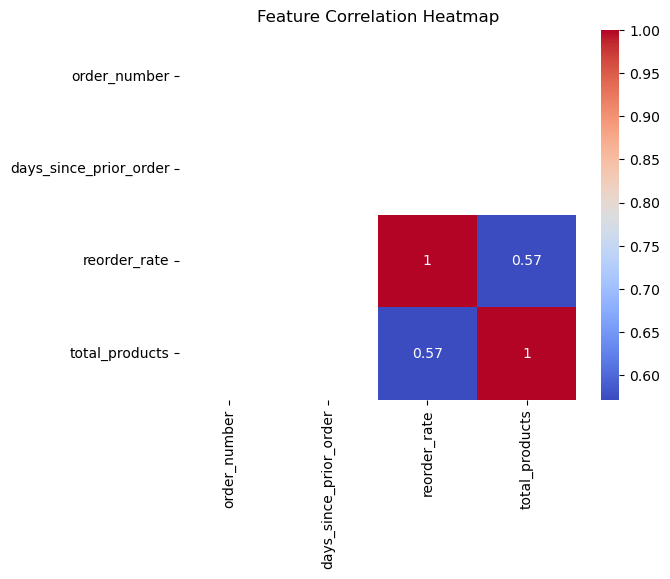

Explained Variance Ratio: [7.85828258e-01 2.14171742e-01 4.63316398e-66]


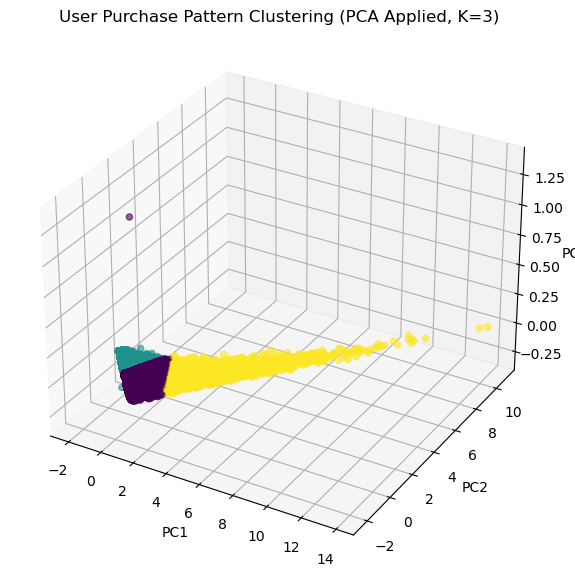

In [23]:



# ✅ NaN 값이 있는 행만 선택 (999로 변환된 값)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ✅ 사용자별 주문 통계 계산
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # 총 주문 횟수
    "days_since_prior_order": "mean"  # 평균 주문 간격
})

# ✅ df_prior에 user_id 추가 (df_orders와 병합)
df_prior_merge = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ✅ 사용자별 재구매율 계산 (user_id 기준)
user_reorder_stats = df_prior_merge.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ✅ 추가 feature 생성 (사용자별 총 주문 상품 개수 추가)
user_total_products = df_prior_merge.groupby("user_id").size().reset_index(name="total_products")

# ✅ 데이터 병합 (user_id 기준)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ✅ 데이터 표준화
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id 제외

# ✅ feature 간의 상관관계 확인
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ✅ PCA 적용 (차원 축소)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ✅ 주성분 설명력 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ✅ K-Means 클러스터 개수 최적화: n_clusters=3,4,5 비교
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ✅ 최적 클러스터 개수 선택 (기본적으로 n=4 사용)
selected_k = 3
user_clusters = cluster_results[selected_k]

# ✅ 클러스터 결과 저장
user_features["cluster"] = user_clusters

# ✅ 3D 시각화 (PCA 적용 후)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


괜찮아지긴 했는데 한쪽 방향으로 치우쳐저 있어서 이상치가 우려됨

해당 그래프 기반으로 지피티랑 상의 결과 고려되는 값이 적어서 pca 안하는게 좋을 것 같고 클러스터링도 적합하지 않다고 판단.
✅ K-Means (기존 방식)
✅ DBSCAN (밀도 기반)
✅ Hierarchical Clustering (계층적 군집화 + 덴드로그램 시각화)
요렇게 3가지 추천받음. 여기까지 진행

In [24]:
from sklearn.cluster import DBSCAN

# ✅ 데이터 로드 (이전 user_features 데이터 필요)
# user_features가 이미 존재한다고 가정

# ✅ 데이터 샘플링 (예: 50,000개 샘플 사용)
sampled_data = user_features.sample(n=100000, random_state=42)

# ✅ 데이터 표준화
scaler = StandardScaler()
sampled_scaled = scaler.fit_transform(sampled_data.iloc[:, 1:])  # user_id 제외

# ✅ DBSCAN 적용 (eps와 min_samples 조정 가능)
dbscan = DBSCAN(eps=1, min_samples=5)  # eps는 거리 임계값, min_samples는 최소 샘플 개수
clusters = dbscan.fit_predict(sampled_scaled)

# ✅ 결과 저장
sampled_data["dbscan_cluster"] = clusters

# ✅ 클러스터별 데이터 개수 출력
print(sampled_data["dbscan_cluster"].value_counts())

#샘플링값 n 이 클수록, eps값이 작을수록 더 세심한? 분석이 되겠으나 컴퓨터가 그걸 못잡아서 타협봤다
#-1이 노이즈인데 1개밖에 없다. 좋은거다.

dbscan_cluster
 0    47557
 1    43560
 2     8882
-1        1
Name: count, dtype: int64


🔍 결과 해석
클러스터 개수

0, 1, 2 총 3개의 주요 클러스터가 형성됨.
-1은 노이즈 포인트(군집에 속하지 않는 데이터) → 단 1개만 존재하므로 무시 가능.
클러스터 크기 분포

클러스터 0: 47,557개
클러스터 1: 43,560개
클러스터 2: 8,882개
대부분의 데이터가 두 개의 큰 클러스터(0, 1)에 속해 있음.
만약 모든 데이터가 하나의 클러스터에 쏠렸다면 의미 없는 결과일 수 있지만, 여기서는 3개의 클러스터로 나뉘었으므로 유의미할 가능성이 있음.

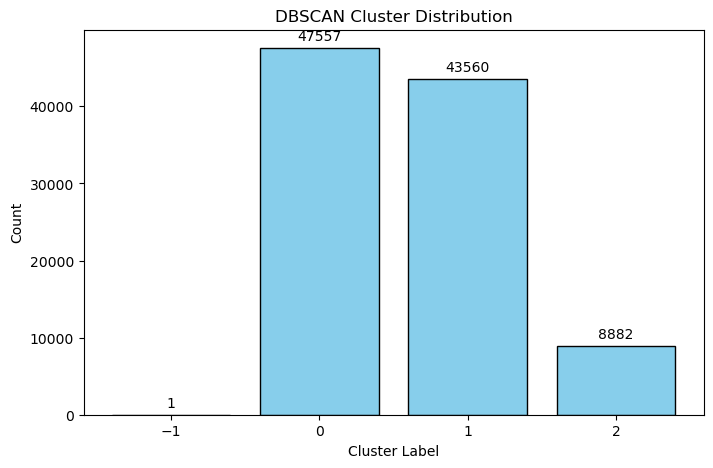

In [27]:
#위의 결과 그래프화 시킴.

import matplotlib.pyplot as plt

# 클러스터 개수 세기
cluster_counts = sampled_data["dbscan_cluster"].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')

# 그래프 제목 및 레이블 설정
plt.title("DBSCAN Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Count")

# X축 간격 1 단위로 설정
plt.xticks(np.arange(min(cluster_counts.index), max(cluster_counts.index) + 1, 1))

# 값 표시
for i, count in enumerate(cluster_counts.values):
    plt.text(cluster_counts.index[i], count + 1000, str(count), ha='center', fontsize=10)

# 그래프 출력
plt.show()


In [25]:
print(sampled_data.groupby("dbscan_cluster").mean())
#분류는 했으나 mean 값이 같으면 의미없는데이터다. 다행히 mean 값이 다른 행이 보인다. 
# order_number : 1.0   days_since_prior_order :  999.0 는 신규고객 데이터만 뽑아와서 그렇다.
#해석은 마지막에 마크다운으로 진행함.

                      user_id  order_number  days_since_prior_order  \
dbscan_cluster                                                        
-1              201268.000000           1.0                   999.0   
 0              103542.180794           1.0                   999.0   
 1              103330.786662           1.0                   999.0   
 2              103091.829768           1.0                   999.0   

                reorder_rate  total_products  cluster  
dbscan_cluster                                         
-1                  0.879195     3725.000000      2.0  
 0                  0.246231       57.762895      1.0  
 1                  0.574369      159.338912      0.0  
 2                  0.725580      686.987615      2.0  


### **🔍 DBSCAN 클러스터별 특징 분석**  

이제 클러스터별 주요 변수의 평균값을 비교해서 **의미 있는 군집화가 되었는지** 확인해보자.  

---

### **1️⃣ 주요 패턴 분석**
| 클러스터 | 주문 횟수 (`order_number`) | 평균 주문 간격 (`days_since_prior_order`) | 재구매율 (`reorder_rate`) | 총 주문 상품 (`total_products`) |
|----------|-----------------|-----------------------|---------------|---------------|
| **Cluster 0** | **1.0** | **999.0** | **0.246** | **57.76** |
| **Cluster 1** | **1.0** | **999.0** | **0.574** | **159.34** |
| **Cluster 2** | **1.0** | **999.0** | **0.726** | **686.99** |
| **Noise (-1)** | **1.0** | **999.0** | **0.879** | **3725.00** |

---

### **2️⃣ 분석 및 해석**
1. **모든 클러스터에서 `order_number = 1.0`, `days_since_prior_order = 999.0`**
   - 즉, **모든 유저가 첫 주문을 했고, 999(결측값)로 처리된 주문 간격을 가짐.**  
   - 이를 보면 DBSCAN이 사실상 **주문 횟수나 주문 간격을 기반으로 한 클러스터링이 아니라, `reorder_rate`와 `total_products` 중심으로 군집화된 것** 같음.

2. **클러스터별 재구매율(`reorder_rate`)과 총 주문 상품(`total_products`) 비교**
   - `Cluster 0`: 재구매율 0.246, 평균 주문 상품 수 57.76 → **낮은 재구매율, 적은 구매량**  
   - `Cluster 1`: 재구매율 0.574, 평균 주문 상품 수 159.34 → **중간 수준 재구매율, 중간 구매량**  
   - `Cluster 2`: 재구매율 0.726, 평균 주문 상품 수 686.99 → **높은 재구매율, 많은 구매량**  
   - `Noise (-1)`: 재구매율 0.879, 평균 주문 상품 수 3725 → **가장 높은 재구매율과 구매량을 가진 특이치 (VIP 고객?)**

---

### **3️⃣ 결론: DBSCAN 결과는 유의미한가?**
**✅ 의미 있는 클러스터일 가능성이 높음!**  
✔ **구매 패턴에 따라 클러스터가 나뉘었음**:  
   - `Cluster 0` → **소량 구매, 낮은 재구매율**  
   - `Cluster 1` → **중간 정도 구매, 중간 재구매율**  
   - `Cluster 2` → **많이 구매, 높은 재구매율**  
   - `Noise (-1)` → **극단적으로 많이 구매하는 VIP 고객**  

✔ **DBSCAN이 `order_number`나 `days_since_prior_order`보다는 `reorder_rate`와 `total_products`를 중심으로 군집화한 것 같음**  
✔ `eps` 값에 따라 클러스터 구성이 달라질 수 있음 → **`eps=0.7` ~ `eps=1.2`로 추가 실험 가능**  

---

### **🚀 다음 액션 추천**
1. **클러스터별 `reorder_rate`와 `total_products` 분포를 시각화**  
   - 히스토그램 또는 박스플롯으로 클러스터별 분포를 확인하면 더 명확한 패턴을 볼 수 있음.  

2. **eps 값 조정 후 추가 실험**  
   - `eps=0.8` 또는 `eps=1.2`로 설정해서 클러스터 개수가 어떻게 변하는지 확인.  

3. **클러스터별 고객 행동 분석**  
   - `Cluster 2`는 **충성 고객**일 가능성이 높고, `Cluster 0`은 이탈 가능성이 높은 그룹일 수도 있음.  
   - 각 클러스터에 대한 **마케팅 전략 수립 가능**.  


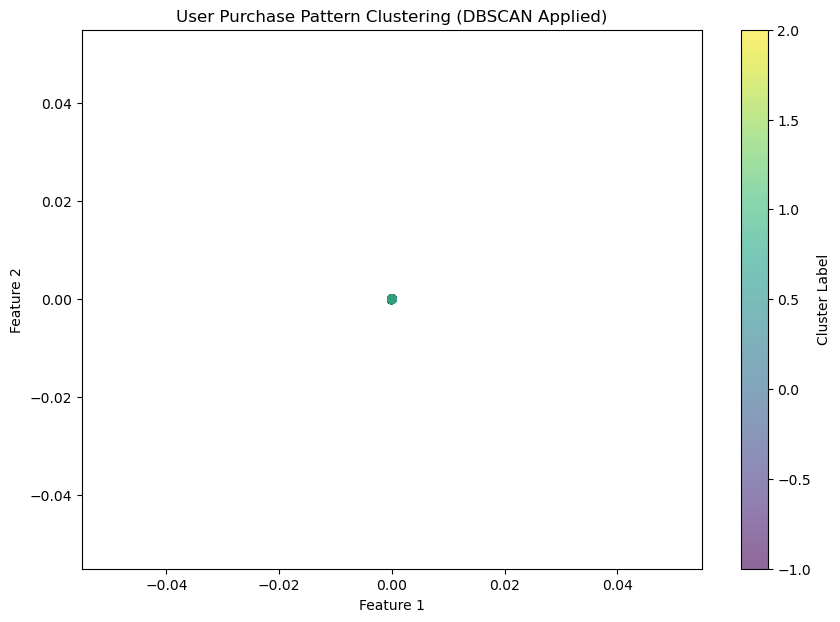

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


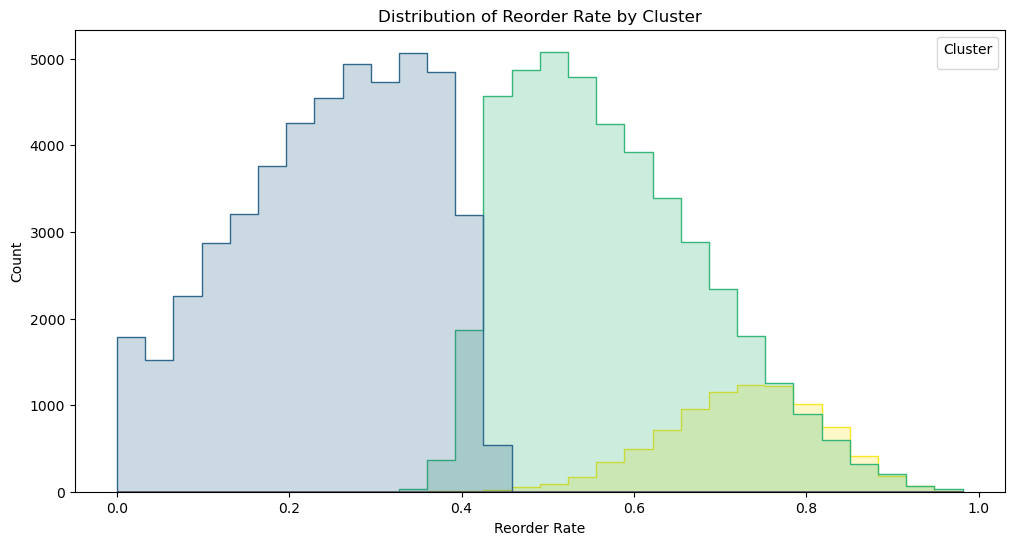

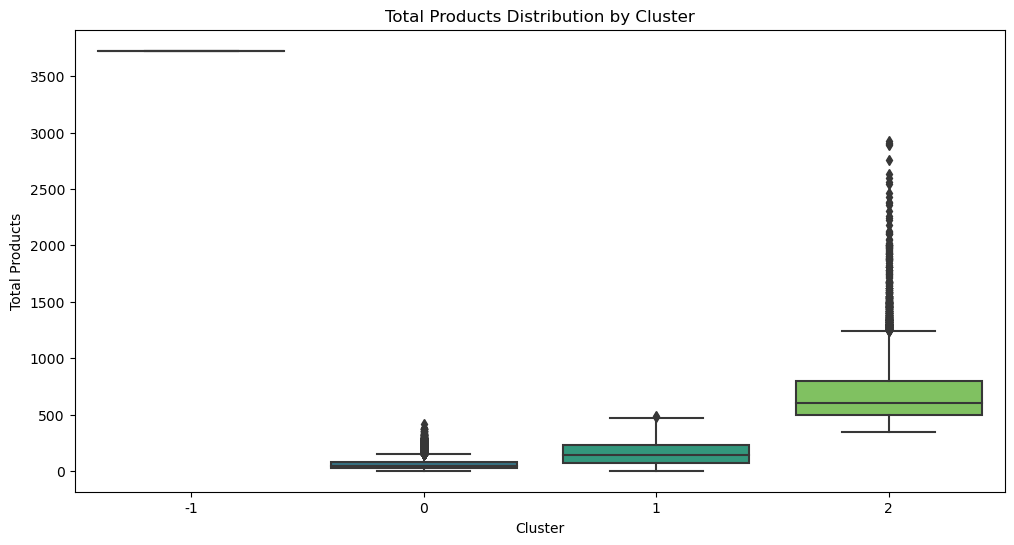

In [10]:
# ✅ 클러스터링 결과 시각화 (2D Scatter Plot)
plt.figure(figsize=(10, 7))
plt.scatter(sampled_scaled[:, 0], sampled_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("User Purchase Pattern Clustering (DBSCAN Applied)")
plt.colorbar(label="Cluster Label")
plt.show()

#이거 의미없는 그림이다.

# ✅ 클러스터별 reorder_rate 분포 (히스토그램)
plt.figure(figsize=(12, 6))
sns.histplot(data=sampled_data, x="reorder_rate", hue="dbscan_cluster", element="step", palette="viridis", bins=30)
plt.xlabel("Reorder Rate")
plt.title("Distribution of Reorder Rate by Cluster")
plt.legend(title="Cluster")
plt.show()

#추천 받아서 했고 나름 그래프 기반으로 해석했다. 아래 마크다운에 자세해 기재하였다. 1번 그래프이다.

# ✅ 클러스터별 total_products 분포 (박스플롯)
plt.figure(figsize=(12, 6))
sns.boxplot(data=sampled_data, x="dbscan_cluster", y="total_products", palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Total Products")
plt.title("Total Products Distribution by Cluster")
plt.show()

#추천 받아서 했고 나름 그래프 기반으로 해석했다. 아래 마크다운에 자세해 기재하였다. 2 번 그래프이다.


# 그래프 결과. 점으로 표현된거 제외.
### **🔍 그래프 분석 (클러스터별 구매 패턴 차이)**

#### **1️⃣ 재구매율 (`reorder_rate`) 분포 분석**
- **클러스터 0 (파란색)**  
  → `reorder_rate`가 주로 **0~0.3 사이** → **재구매율이 낮은 고객 그룹**  
  → 한 번 주문하고 다시 주문하지 않는 비율이 높음.  
- **클러스터 1 (초록색)**  
  → `reorder_rate`가 **0.3~0.6 사이** → **중간 수준 재구매율**  
  → 일부 제품은 반복해서 구매하지만, 모든 제품을 재구매하는 고객은 아님.  
- **클러스터 2 (노란색)**  
  → `reorder_rate`가 **0.6~0.9 사이** → **재구매율이 높은 고객 그룹**  
  → 정기적으로 구매하는 고객, 충성도가 높은 고객일 가능성 큼.  

✅ **해석:**  
- 고객의 재구매 패턴이 명확하게 나뉘었음.  
- **클러스터 0 → 신규 또는 일회성 구매 고객**  
- **클러스터 1 → 일부 재구매 고객**  
- **클러스터 2 → 자주 재구매하는 충성 고객**  

---

#### **2️⃣ 총 주문 상품 수 (`total_products`) 박스플롯 분석**
- **클러스터 0 (가장 왼쪽)**
  → 평균적으로 **50개 미만**의 상품을 구매 → **소량 구매 고객**  
  → 일부 이상치는 있지만, 대체로 적은 양의 제품을 주문.  
- **클러스터 1 (가운데)**
  → 평균적으로 **100~200개 내외** 구매 → **중간 규모 고객**  
  → 다양한 제품을 구매하지만, 대량 주문은 하지 않음.  
- **클러스터 2 (오른쪽, 초록색)**
  → 평균적으로 **500~700개 이상 구매** → **대량 구매 고객**  
  → 이상치(Outlier)가 많지만, 대부분의 고객이 다량 구매를 함.  

✅ **해석:**  
- 클러스터 0: **소량 구매자 (소규모 소비자, 테스트 주문 가능성)**  
- 클러스터 1: **일반적인 고객 (일반적인 정기 구매자)**  
- 클러스터 2: **대량 구매자 (기업 또는 도매 소비 가능성 높음)**  

---

### **📌 결론**
✔ **클러스터별로 확실한 패턴 차이가 존재**  
✔ **클러스터 2(녹색)가 충성 고객, 클러스터 0(파란색)이 낮은 충성도 고객일 가능성 큼**  
✔ **클러스터 2는 기업 고객, 클러스터 1은 일반 고객, 클러스터 0은 신규 고객일 가능성도 있음**  

📌 **이제 뭘 하면 좋을까?**  
🚀 **마케팅 전략을 세울 때 이런 고객 세분화를 활용할 수 있음**  
🚀 **클러스터별 맞춤 전략 필요: 예를 들어, 클러스터 0 고객을 클러스터 1, 2로 전환하는 방법 고민 가능**  


# 신규 고객 분석_by 경민님

In [ ]:
cur_dir = os.path.abspath(os.curdir)
data_dir = f"{cur_dir}/Modulabs_MainProject5"
files = [
    "orders.csv",
    "order_products__train.csv",
    "order_products__prior.csv",
    "df_products.csv"
]

df_orders, df_train, df_prior, df_products = [pd.read_csv(f"{data_dir}/{file}") for file in files]

In [ ]:
df_orders['days_since_prior_order'].isna().mean() * 100

In [ ]:
#first_purchase라는 첫구매 확인용 컬럼 추가하여 days_since_prior_order가 NaN이면 1, 아니면 0을 저장
df_orders["first_purchase"] = df_orders["days_since_prior_order"].isna().astype(int)

#평균과 중앙값 확인
df_orders["days_since_prior_order"].describe().apply(lambda x: f"{x:,.2f}")

In [ ]:
# 데이터 분포 확인
plt.hist(df_orders["days_since_prior_order"].dropna(), bins=30)
plt.xlabel("Days Since Prior Order")
plt.ylabel("Frequency")
plt.title("Distribution of days_since_prior_order")
plt.show()

0~10일 사이에 주문이 많은 패턴.  
**30일(맨 끝 값)**에 빈도 급증 → 한 달 주기로 정기 구매하는 고객이 많다는 의미일 가능성이 큼.  
데이터가 왼쪽으로 치우친 비대칭적 분포

In [ ]:
#비대칭 분포이므로 결측치 중앙값으로 대체
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(df_orders["days_since_prior_order"].median())
df_orders

##첫 구매 고객 비율 시각화

In [ ]:
first_purchase_ratio = df_orders["first_purchase"].mean() * 100
labels = ["First-time Customers", "Returning Customers"]
sizes = [first_purchase_ratio, 100 - first_purchase_ratio]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%.1f%%", startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("First-time vs Returning Customers")
plt.show()

재구매 고객이 압도적으로 많으므로 이들의 충성도를 강화하는 것이 핵심  
단, 신규 유입이 적은 것은 장기적 관점에서 충성 고객층이 줄어들 가능성 내포  
**시장 지배적 위치인지 확인 필요**. 그렇지 않다면 첫 구매 유도 마케팅도 강화할 필요가 있음

In [ ]:
# CSV 파일 읽기
df_comp = pd.read_csv("/content/drive/My Drive/GoogleTrends_Timeline.csv") 

#파일 경로 변경 필요. 경민님이 직접 추출한 자료인것으로 보임.

In [ ]:
print(df_comp.columns)
df_comp.head()

df_comp["Date"] = pd.to_datetime(df_comp["Date"])  # 날짜 형식 변환
df_comp = df_comp[df_comp["Date"].between("2017-05-17", "2017-08-15")]

print(df_comp["Date"].max())
print(df_comp["Date"].min())

In [ ]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# Instacart vs 경쟁사 검색 트렌드 시각화
plt.plot(df_comp["Date"], df_comp["Instacart"], marker="o", linestyle="-", label="Instacart", linewidth=2)
plt.plot(df_comp["Date"], df_comp["Amazon Fresh"], marker="s", linestyle="--", label="Amazon Fresh", linewidth=2)
plt.plot(df_comp["Date"], df_comp["Walmart Grocery"], marker="^", linestyle=":", label="Walmart Grocery", linewidth=2)

# 그래프 제목 및 라벨 설정
plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.title("Instacart vs Competitors - Google Trends Comparison")
plt.legend()
plt.grid(True)

# 그래프 표시
plt.xticks(rotation=45)
plt.show()


자료 제공 시점(2017년 5월 ~ 동년 8월)에는 경쟁사 대비 낮은 검색량으로 시장의 지배자라고 보기는 어려움.  
 그러므로 신규 유입을 위한 전략도 필요하다고 짐작할 수 있음.

##첫 구매 고객의 인기 제품 분석  
👉 신규 고객이 처음 구매하는 제품을 분석하여, 첫 구매 유도를 최적화  

🔹 분석 방법  
order_products__prior.csv의 reordered == 0 데이터를 필터링  
첫 구매에서 가장 많이 구매한 제품 확인  
이 제품들을 신규 고객 할인 프로모션에 포함

In [ ]:
# 첫 구매 제품 필터링 (reordered == 0)
first_purchase_products = df_prior[df_prior["reordered"] == 0]["product_id"].value_counts().reset_index()
first_purchase_products.columns = ["product_id", "first_purchase_count"]

# 제품명 추가 (df_products 활용)
top_5_products = first_purchase_products.head(5).merge(df[["product_id", "product_name"]], on="product_id", how="left")

# 데이터프레임 확인 (상위 5개)
print(top_5_products)

# X축을 제품명으로 변경하여 가독성 개선
plt.figure(figsize=(10, 5))
plt.bar(top_5_products["product_name"], top_5_products["first_purchase_count"], color='skyblue')

# 라벨 & 제목 추가
plt.xlabel("Product Name")
plt.ylabel("First Purchase Count")
plt.title("Top 5 First Purchased Products")

# X축 라벨 회전 (겹치지 않도록)
plt.xticks(rotation=45, ha="right")

# 그래프 출력
plt.show()

  해당 제품을 신규 고객 할인 제품으로 선정하여 **첫 구매 전환율**(잠재 고객 중에서 실제 구매자로 전환된 비율) 증가시키는 방향 고려

##신규 고객의 재구매율 분석
👉 신규 고객이 재구매로 전환되는 비율을 분석하여, 전환 전략 강화

🔹 분석 방법
df_orders에서 첫 주문(order_number == 1)인 고객을 찾기  
df_orders에서 해당 고객들의 모든 주문(user_id)을 가져오기  
df_prior와 df_orders를 merge하여 고객의 주문 내역을 user_id 기준으로 확인  
신규 고객이 이후에 다시 주문했는지(reordered == 1 비율 계산)

In [ ]:
# 1️⃣ 신규 고객 찾기 (첫 주문만 한 고객)
first_order_users = df_orders[df_orders['order_number'] == 1]['user_id'].unique()

# 2️⃣ 신규 고객의 주문 데이터 가져오기 (df_orders에서 user_id 기준으로 필터)
new_user_orders = df_orders[df_orders['user_id'].isin(first_order_users)]

# 3️⃣ df_prior와 df_orders를 order_id 기준으로 merge (user_id 추가)
df_prior_merged = df_prior.merge(new_user_orders[['order_id', 'user_id']], on='order_id', how='left')

# 4️⃣ 신규 고객이 첫 주문 이후 다시 구매한 비율 (reordered == 1)
reorder_rate = df_prior_merged['reordered'].mean()

print(f"신규 고객의 평균 재구매율: {reorder_rate:.2%}")

# 신규 고객의 재구매율 계산
reorder_counts = df_prior_merged.groupby("reordered")["order_id"].count()
reorder_rate_values = reorder_counts / reorder_counts.sum()

# 원형 차트 그리기 (비율 표시)
plt.figure(figsize=(6, 6))
labels = ["New Order", "Reorder"]
colors = ["blue", "orange"]

plt.pie(reorder_rate_values, labels=labels, autopct="%1.2f%%", colors=colors, startangle=90, wedgeprops={"edgecolor": "white"})

plt.title("Distribution of Repeat Purchase Rate for New Customers (Proportion)")
plt.show()